In [ ]:
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return false;
# }

<IPython.core.display.Javascript object>

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from google.cloud import bigquery
import calendar
import time
import os
from datetime import datetime

In [ ]:
PROJECT_ID = '[YOUR-PROJECT-ID]'
DATASET = '[YOUR-DATASET]'
TABLE = 'data_source'

from google.colab import auth
auth.authenticate_user()

### Look at source data

In [88]:
qry_original = """
SELECT
  DATETIME_DIFF(
    PARSE_DATETIME("%m/%d/%y %H:%M", InvoiceDate), mm.mind, DAY) AS day_number,
  *
FROM
  `{p}.{d}.{t}`,
  (
  SELECT
    MIN(PARSE_DATETIME("%m/%d/%y %H:%M", InvoiceDate)) mind,
    MAX(PARSE_DATETIME("%m/%d/%y %H:%M", InvoiceDate)) maxd
  FROM
    `{p}.{d}.{t}`) mm {w}
"""

where_sample = """
WHERE
  -- 1 in 50 so we get about 500000 records out of 10000
  MOD(ABS(FARM_FINGERPRINT( 
    CONCAT(
      CAST(InvoiceNo AS STRING),
      CAST(Quantity AS STRING),
      CAST(InvoiceDate AS STRING),
      CAST(UnitPrice AS STRING),
      CAST(CustomerID AS STRING)
    ) )), 50) = 1
"""

df_original = pd.io.gbq.read_gbq(qry_original.format(p=PROJECT_ID, d=DATASET, t=TABLE, w=where_sample), 
                                 project_id=PROJECT_ID, 
                                 dialect='standard')

print(df_original.head(2))
df_original.describe()

   day_number InvoiceNo StockCode Description  Quantity     InvoiceDate  \
0          90    545332         M      Manual         1  03/01/11 03:52   
1         337    574252         M      Manual         1  11/03/11 01:24   

   UnitPrice CustomerID Country                mind                maxd  
0     183.75      12352  Norway 2010-12-01 01:04:00 2011-12-09 12:50:00  
1       0.00      12437  France 2010-12-01 01:04:00 2011-12-09 12:50:00  


,day_number,Quantity,UnitPrice
count,7974.000000,7974.000000,7974.000000
mean,221.630298,12.244043,3.088569
std,112.506385,43.805342,7.036266
min,0.000000,-144.000000,0.000000
25%,130.000000,2.000000,1.250000
50%,240.000000,5.000000,1.950000
75%,323.000000,12.000000,3.750000
max,373.000000,1500.000000,295.000000


In [5]:
# df_original = pd.read_excel('../data/Online_Retail.xlsx')
df_original = pd.read_csv('../data/Online_Retail.csv')
print(df_original.head(1))
df_original.describe()

  InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [17]:
# raw_df = df_original
# df_original = raw_df

In [30]:
def config(df_original):
    # Copy df
    df = df_original.copy()

    # Change date to datetime object
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

    # Find difference in dates
    today = np.max(df['InvoiceDate'])
    difference = df['InvoiceDate'] - today
    df['difference'] = abs(difference.dt.days)
    
    # Get day from datetime
    # df['day_number'] = df['InvoiceDate'].dt.day_of_year

    # Group
    df = df.groupby(by=['difference', 'CustomerID', 'StockCode']).sum().reset_index().sort_values(by=['Quantity'], ascending=False)

    # Crear variables
    df['order_value'] = df['Quantity'] * df['UnitPrice']

    # Quitar variables
    df = df.drop(columns=['StockCode'])

    # Keep only records with + Quantity and + order_value OR - Quantity
    df = df[(df['Quantity'] > 0) & (df['order_value'] > 0) | (df['Quantity'] < 0)]
    
    return df

config(df_original)

,difference,CustomerID,Quantity,UnitPrice,order_value
86976,44,12901.0,4800,0.21,1008.00
250567,197,13135.0,4300,0.72,3096.00
332757,291,18087.0,3906,0.82,3202.92
205034,143,14609.0,3186,0.06,191.16
360685,332,15749.0,3114,2.10,6539.40
...,...,...,...,...,...
122364,66,14533.0,-1200,0.07,-84.00
112969,60,16029.0,-1296,3.18,-4121.28
283720,235,15749.0,-1300,2.55,-3315.00
265564,211,18133.0,-1350,0.16,-216.00


<AxesSubplot:xlabel='day_number', ylabel='Density'>

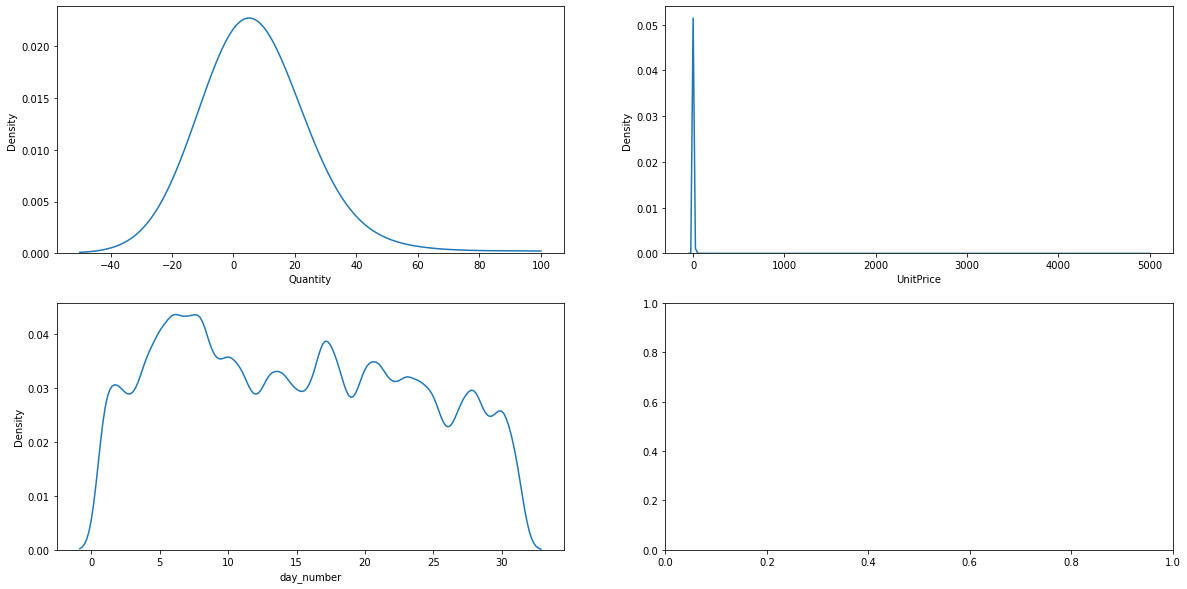

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# distplot not as easy to clip
# sns.distplot( df_original['Quantity'], ax=axs[0], label='quantity')
# sns.distplot(df_original['UnitPrice'], ax=axs[1], label='price')

sns.kdeplot(df_original['Quantity'], ax=axs[0, 0], label='quantity', clip=(-50, 100))
sns.kdeplot(df_original['UnitPrice'], ax=axs[0, 1], label='price', clip=(-50, 5000))
sns.kdeplot(df_original['day_number'], ax=axs[1, 0], label='days')

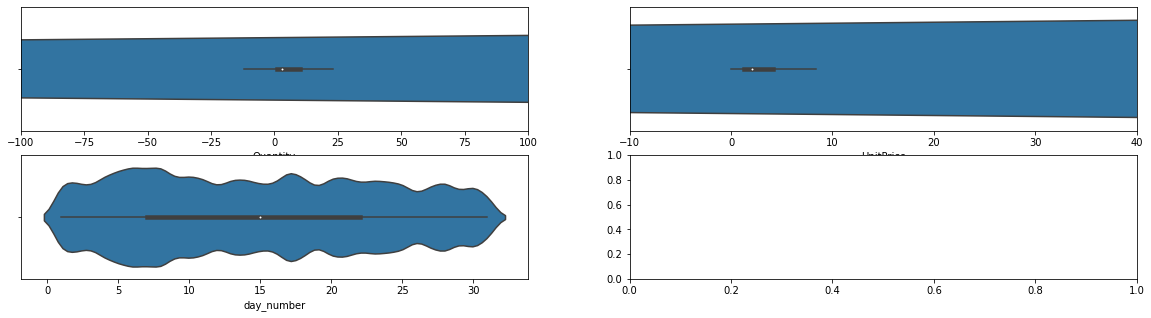

In [16]:
figv, axsv = plt.subplots(nrows=2, ncols=2, figsize=(20, 5))

axq = sns.violinplot(x=df_original["Quantity"], ax=axsv[0, 0])
axq.set_xlim(-100, 100)

axp = sns.violinplot(x=df_original["UnitPrice"], ax=axsv[0, 1])
axp.set_xlim(-10, 40)

axd = sns.violinplot(x=df_original["day_number"], ax=axsv[1, 0])

Day 250 seems to represent a decent threshold data (more than 50% of the orders happened before that day but less than 75%

Would use this query:

In [ ]:
threshold_qry = """
SELECT
  DATETIME_ADD(mind, INTERVAL 250 DAY)
FROM
  (
  SELECT
    MIN(PARSE_DATETIME("%m/%d/%y %H:%M", InvoiceDate)) mind,
    MAX(PARSE_DATETIME("%m/%d/%y %H:%M", InvoiceDate)) maxd
  FROM
    `{}.{}.{}`) mm
"""

### RFMT

In [52]:
# Frequency of Repeat transaction
repeat_transactions_query = """
SELECT
  customer_id,
  COUNT(DISTINCT order_date) -1 AS num_transactions
FROM
  `{}.{}.data_cleaned`
GROUP BY
  customer_id"""
repeat_transactions_query = repeat_transactions_query.format(PROJECT_ID, DATASET)

df_repeat_transactions = pd.io.gbq.read_gbq(query=repeat_transactions_query, dialect ='standard', project_id=PROJECT_ID)
print(df_repeat_transactions.head(2))
df_repeat_transactions.describe()

  customer_id  num_transactions
0       16915                 5
1       15349                 1


,num_transactions
count,1650.000000
mean,7.436364
std,9.308011
min,1.000000
25%,3.000000
50%,5.000000
75%,9.000000
max,141.000000


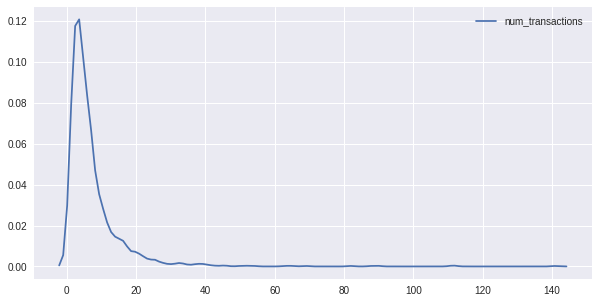

In [60]:
fig, axs = plt.subplots(figsize=(10, 5))
sns.kdeplot(df_repeat_transactions['num_transactions'])

In [55]:
recency_query = """
SELECT
  customer_id,
  DATE_DIFF(MAX(order_date), MIN(order_date), DAY) recency
FROM
  `{}.{}.data_cleaned`
GROUP BY
  customer_id"""
recency_query = recency_query.format(PROJECT_ID, DATASET)

df_recency = pd.io.gbq.read_gbq(query=recency_query, dialect ='standard', project_id=PROJECT_ID)
print(df_recency.head(2))
df_recency.describe()

  customer_id  recency
0       16676      304
1       12901      262


,recency
count,1650.000000
mean,256.879394
std,90.692561
min,1.000000
25%,197.250000
50%,272.500000
75%,337.750000
max,373.000000


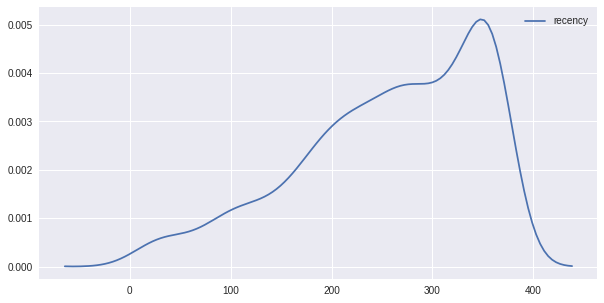

In [59]:
fig, axs = plt.subplots(figsize=(10, 5))
sns.kdeplot(df_recency['recency'])

### Monetary

In [57]:
monetary_query = """
SELECT
  customer_id,
  SUM(order_value) AS monetary
FROM
  `{}.{}.data_cleaned`
GROUP BY
  customer_id"""
monetary_query = monetary_query.format(PROJECT_ID, DATASET)

df_monetary = pd.io.gbq.read_gbq(query=monetary_query, dialect ='standard', project_id=PROJECT_ID)
print(df_monetary.head(2))
df_monetary.describe()

  customer_id  monetary
0       16676   1558.72
1       12901  16293.10


,monetary
count,1650.000000
mean,3973.304164
std,12993.748834
min,36.560000
25%,935.362500
50%,1767.770000
75%,3429.125000
max,279489.020000


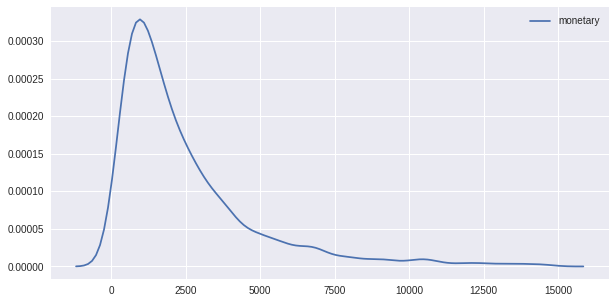

In [76]:
fig, axs = plt.subplots(figsize=(10, 5))
sns.kdeplot(df_monetary['monetary'], clip=(-1000, 15000))

We can clip the monetary data at 15000